In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:

actions = ['up','down','left','right','Rotate clockwise','Rotate counter-clockwise','shoot']
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        # Define action and observation spaces
        self.grid_size = 1024
        self.grid = np.zeros((self.grid_size, self.grid_size, 3), dtype=np.uint8)
        self.action_space = spaces.Discrete(7) 

        self.laction1 = -1
        self.laction2 = -1
        # Initialize agent positions and orientations
        self.agent1_pos = [512, 512]  # Initial position of agent 1
        self.agent2_pos = [256, 256]  # Initial position of agent 2
        self.agent1_facing = 90 
        self.agent2_facing = 270

        self.agent_size = 20

        self.reward1 = 0
        self.reward2 = 0

        #self.fig, self.ax = plt.subplots()
        #self.im = self.ax.imshow(self.grid)

    def get_direction(self,agentAttacking,agentDefending):
        x_diff = agentDefending[0] - agentAttacking[0]
        y_diff = agentDefending[1] - agentAttacking[1]
        return math.degrees(math.atan2(y_diff, x_diff))

    def step(self, action1, action2):
        self.reward1 -= 1
        self.reward2 -= 1
        self.laction1 = action1
        self.laction2 = action2
        if action1 == 0:  # Move up
            self.agent1_pos[1] -= 1
        elif action1 == 1:  # Move down
            self.agent1_pos[1] += 1
        elif action1 == 2:  # Move left
            self.agent1_pos[0] -= 1
        elif action1 == 3:  # Move right
            self.agent1_pos[0] += 1
        elif action1 == 4:  # Rotate clockwise
            self.agent1_facing += 10
        elif action1 == 5:  # Rotate counter-clockwise
            self.agent1_facing -= 10
        elif action1 == 6:  # Shoot
            diff = self.agent1_facing - self.get_direction(self.agent1_pos,self.agent2_pos)
            if diff!= 0:
                self.reward1 += 360/abs(diff)
            else:
                self.reward1 += 400

        if action2 == 0:  # Move up
            self.agent2_pos[1] -= 1
        elif action2 == 1:  # Move down
            self.agent2_pos[1] += 1
        elif action2 == 2:  # Move left
            self.agent2_pos[0] -= 1
        elif action2 == 3:  # Move right
            self.agent2_pos[0] += 1
        elif action2 == 4:  # Rotate clockwise
            self.agent2_facing += 10
        elif action2 == 5:  # Rotate counter-clockwise
            self.agent2_facing -= 10
        elif action2 == 6:  # Shoot
            diff = self.agent2_facing - self.get_direction(self.agent2_pos,self.agent1_pos)
            if diff!= 0:
                self.reward1 += 360/abs(diff)
            else:
                self.reward1 += 400

        self.agent1_pos[0] = max(0, min(self.agent1_pos[0], 1023))
        self.agent1_pos[1] = max(0, min(self.agent1_pos[1], 1023))
        self.agent2_pos[0] = max(0, min(self.agent2_pos[0], 1023))
        self.agent2_pos[1] = max(0, min(self.agent2_pos[1], 1023))

        observation1 = self._get_observation1()
        observation2 = self._get_observation2()
        done = self.reward1 >= 1000 or self.reward2 >= 1000

        return observation1 , observation2, self.reward1, self.reward2, done, {}
    def _get_grid(self):
        self.grid.fill(0)

        # Draw agents on the grid
        self.grid[self.agent1_pos[1] - self.agent_size // 2:self.agent1_pos[1] + self.agent_size // 2,
                  self.agent1_pos[0] - self.agent_size // 2:self.agent1_pos[0] + self.agent_size // 2] = [255, 0, 0]  # Agent 1 (red)
        self.grid[self.agent2_pos[1] - self.agent_size // 2:self.agent2_pos[1] + self.agent_size // 2,
                  self.agent2_pos[0] - self.agent_size // 2:self.agent2_pos[0] + self.agent_size // 2] = [0, 0, 255]  # Agent 2 (blue)

        return self.grid
    def distance(self, pos1, pos2):
        # Calculate Euclidean distance between pos1 and pos2
        return math.sqrt((pos2[0] - pos1[0]) ** 2 + (pos2[1] - pos1[1]) ** 2)
    def _get_observation1(self):
        # Calculate direction and distance between agents
        direction = int(self.get_direction(self.agent1_pos, self.agent2_pos))
        distance = int(self.distance(self.agent1_pos, self.agent2_pos))
        return direction, distance
    def _get_observation2(self):
        # Calculate direction and distance between agents
        direction = int(self.get_direction(self.agent2_pos, self.agent1_pos))
        distance = int(self.distance(self.agent2_pos, self.agent1_pos))
        return direction, distance
    def reset(self):
        self.agent1_pos = [768, 512] 
        self.agent2_pos = [256, 512]  
        self.agent1_facing = 0
        self.agent2_facing = 180 
        self.reward1 = 0
        self.reward2 = 0
        return self._get_observation1(), self._get_observation2()
    def render(self, mode='human'):
        # Visualize the environment
        self.im.set_data(self._get_grid())
        self.ax.set_title(f'Action 1: {actions[self.laction1]}, Action 2: {actions[self.laction2]}')
        plt.pause(0.1)
        
        

In [5]:
env = CustomEnv()


# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Epsilon for epsilon-greedy policy
num_episodes = 10000  # Number of episodes
max_steps_per_episode = 100  # Maximum number of steps per episode



# Initialize Q-table
action_space_size = env.action_space.n
output_size = env.action_space.n

model1 = DQN(2, output_size).to(device)
model2 = DQN(2, output_size).to(device)

optimizer1 = optim.Adam(model1.parameters(), lr=alpha)
optimizer2 = optim.Adam(model2.parameters(), lr=alpha)
loss_fn = nn.MSELoss()


# Q-learning algorithm
for episode in range(num_episodes):
    state1,state2 = env.reset()
    
    total_reward1 = 0
    total_reward2 = 0
    for step in range(max_steps_per_episode):
        state1_tensor = torch.tensor(state1, dtype=torch.float32).to(device)
        state2_tensor = torch.tensor(state2, dtype=torch.float32).to(device)
        # Choose action
        if np.random.uniform(0, 1) < epsilon:
            action1 = env.action_space.sample()  # Explore action space
        else:
            q_values1 = model1(state1_tensor.unsqueeze(0)) 
            action1 = torch.argmax(q_values1).item()
        if np.random.uniform(0, 1) < epsilon:
            action2 = env.action_space.sample()  # Explore action space
        else:
            q_values2 = model2(state2_tensor.unsqueeze(0)) 
            action2 = torch.argmax(q_values2).item()
        
        # Take action
        next_state1, next_state2, reward1, reward2, done, _ = env.step(action1,action2
                                               )
        
        # Update Q-value
        q_values1_next = model1(torch.tensor(next_state1, dtype=torch.float32).to(device).unsqueeze(0))
        q_values2_next = model2(torch.tensor(next_state2, dtype=torch.float32).to(device).unsqueeze(0))
        target1 = reward1 + gamma * torch.max(q_values1_next)
        target2 = reward2 + gamma * torch.max(q_values2_next)
        q_values1_target = model1(state1_tensor.unsqueeze(0)).squeeze(0).to(device)
        q_values2_target = model2(state2_tensor.unsqueeze(0)).squeeze(0).to(device)
        q_values1_target[action1] = target1
        q_values2_target[action2] = target2
        
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        loss1 = loss_fn(model1(state1_tensor.unsqueeze(0)), q_values1_target.unsqueeze(0))
        loss2 = loss_fn(model2(state2_tensor.unsqueeze(0)), q_values2_target.unsqueeze(0))
        loss1.backward()
        loss2.backward()
        optimizer1.step()
        optimizer2.step()

        total_reward1 += reward1
        total_reward2 += reward2
        state1 = next_state1
        state2 = next_state2
        

        if done:
            break
    
    print(f"Episode: {episode,step}, Total Reward: {total_reward1,total_reward2}")


Episode: (0, 70), Total Reward: (-606.6786028704804, -2556)
Episode: (1, 74), Total Reward: (-779.4391778499157, -2850)
Episode: (2, 9), Total Reward: (55.070193069462235, -55)
Episode: (3, 17), Total Reward: (110.22858075034478, -171)
Episode: (4, 7), Total Reward: (50.026053782529345, -36)
Episode: (5, 11), Total Reward: (56.0, -78)
Episode: (6, 9), Total Reward: (55.01852262313625, -55)
Episode: (7, 3), Total Reward: (24.0000046381057, -10)
Episode: (8, 7), Total Reward: (52.069780899623154, -36)
Episode: (9, 9), Total Reward: (55.16853611235781, -55)
Episode: (10, 13), Total Reward: (67.74431599238022, -105)
Episode: (11, 15), Total Reward: (68.5240779350016, -136)
Episode: (12, 9), Total Reward: (55.0, -55)
Episode: (13, 9), Total Reward: (45.01510224616516, -55)
Episode: (14, 15), Total Reward: (88.0012766037579, -136)
Episode: (15, 9), Total Reward: (60.30650154798761, -55)
Episode: (16, 5), Total Reward: (37.35294117647059, -21)
Episode: (17, 9), Total Reward: (55.0, -55)
Episo

In [36]:
def visualize_q_map(model):
    direction_values = list(range(360))
    distance_values = list(range(1024))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan']
    fig = plt.figure(dpi=200,figsize=(8, 8))
    ax = fig.add_subplot(projection='polar')
    for direction in direction_values:
        radians = np.deg2rad(direction)
        for distance in distance_values:
            state = [direction, distance]
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            q_values = model(state_tensor.unsqueeze(0))
            action = torch.argmax(q_values).item()            
            plt.polar(radians, distance,marker=',', color=colors[action])

    ax.set_theta_direction(-1)  # Set clockwise direction
    ax.set_theta_zero_location("N")  # Set zero degrees at the top
    plt.title('Polar Distance vs. Degree by Actions')
    plt.show()

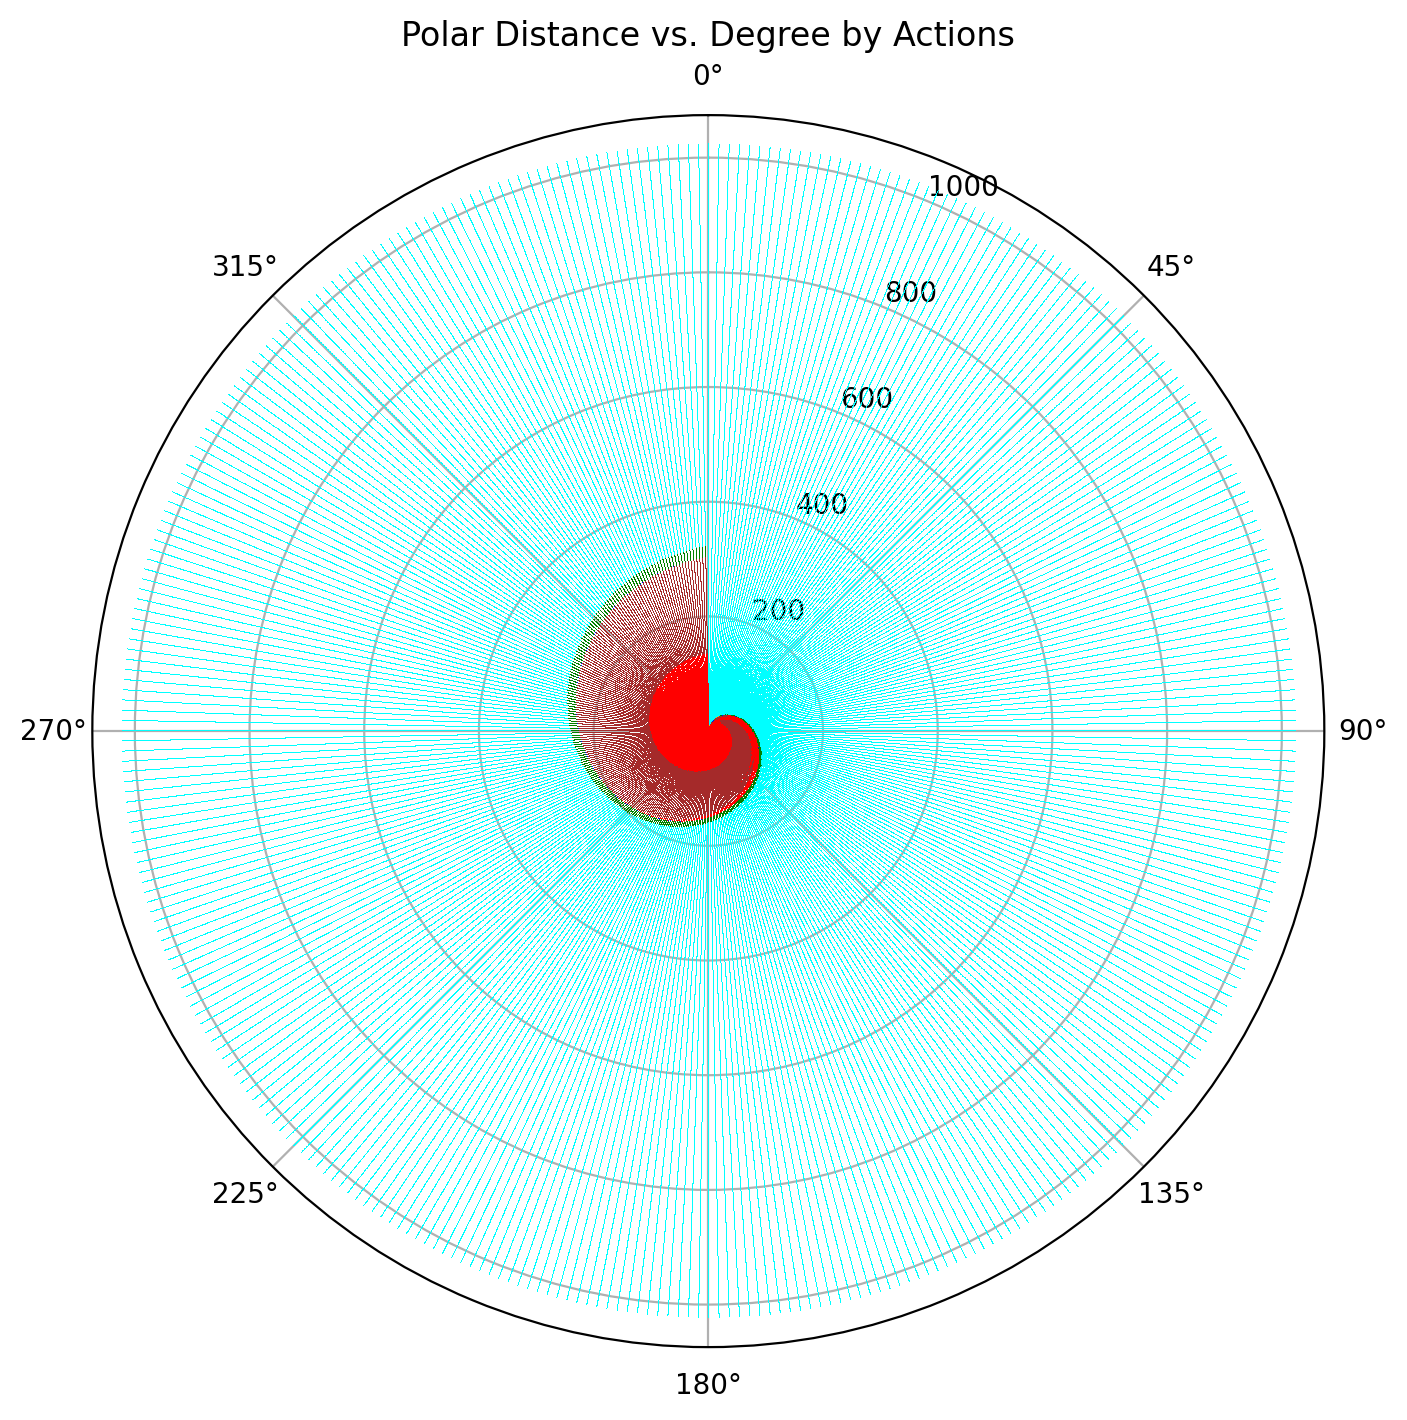

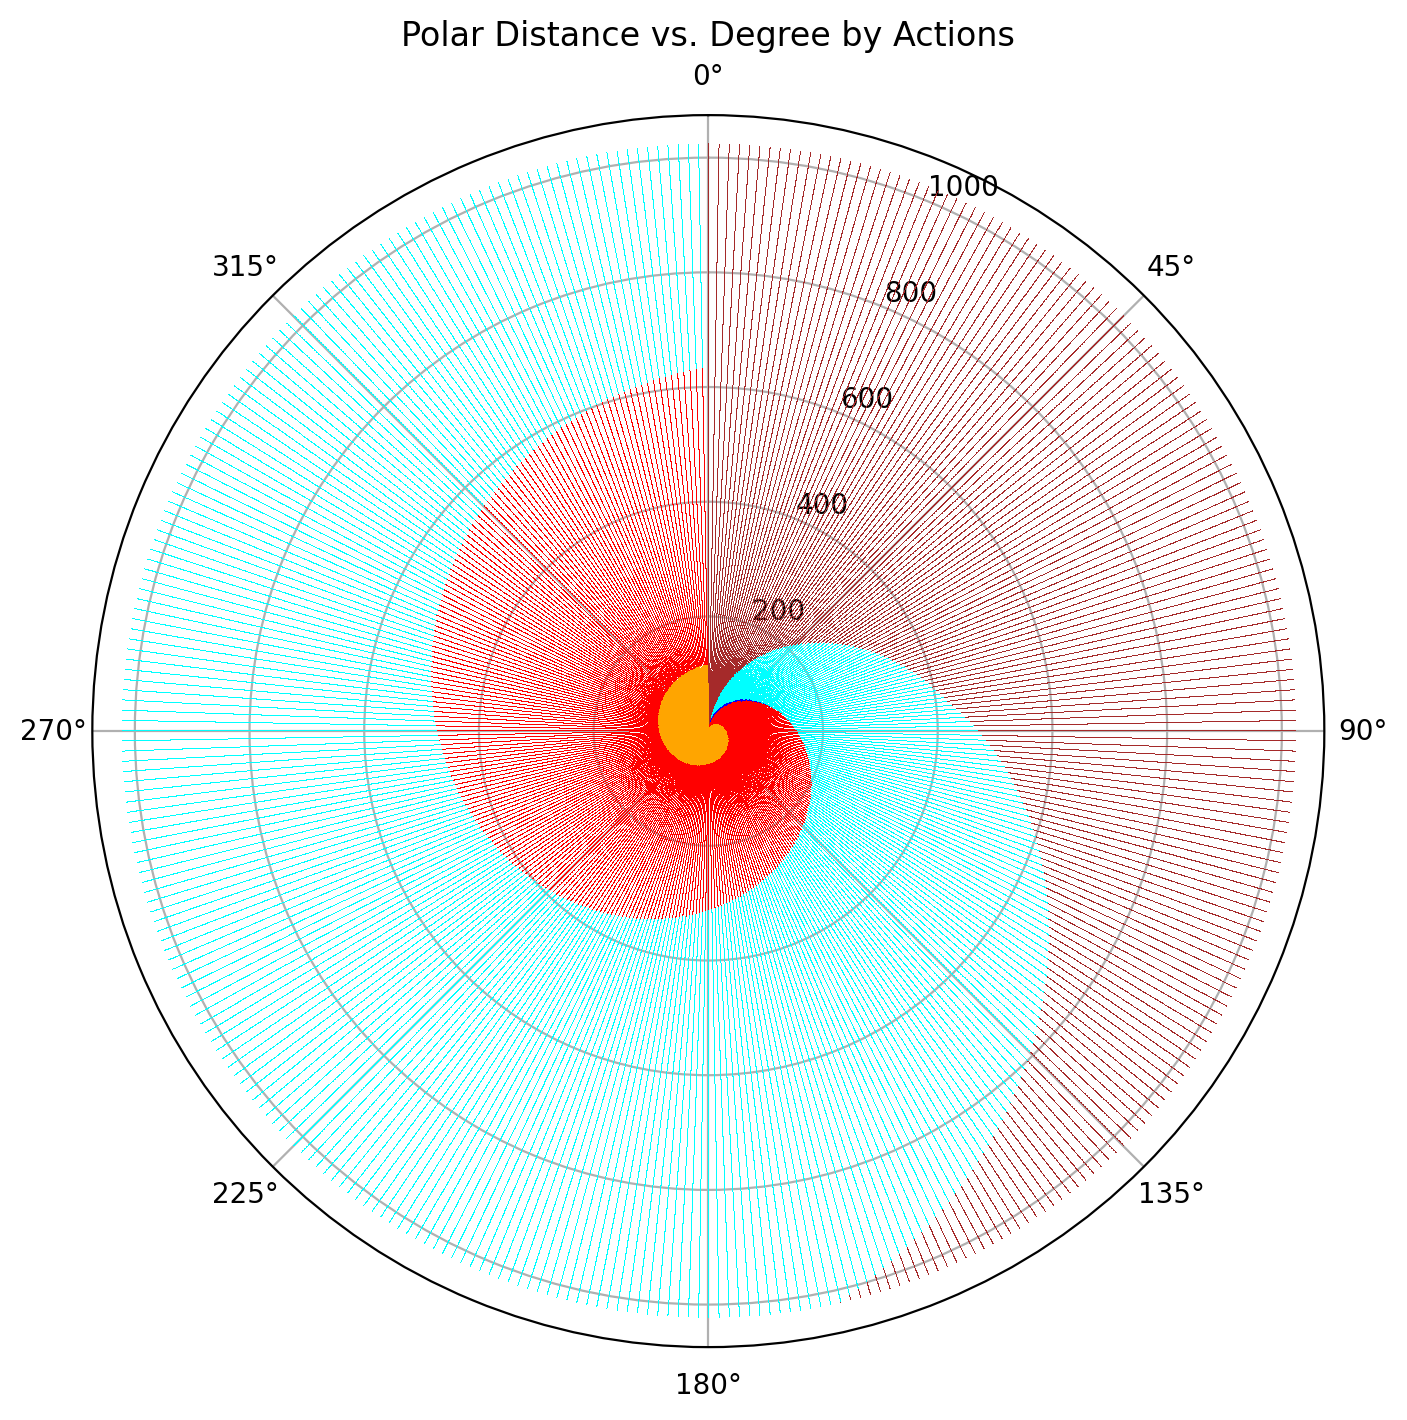

In [37]:
visualize_q_map(model1)
visualize_q_map(model2)